In [1]:
import mxnet as mx
from mxnet import nd, autograd
mx.random.seed(1)

In [2]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
noise = .01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

In [3]:
print(X[0])
print(y[0])


[-0.67765152  0.03629481]
<NDArray 2 @cpu(0)>

[ 2.74159384]
<NDArray 1 @cpu(0)>


In [4]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[ 2.7212944]
<NDArray 1 @cpu(0)>


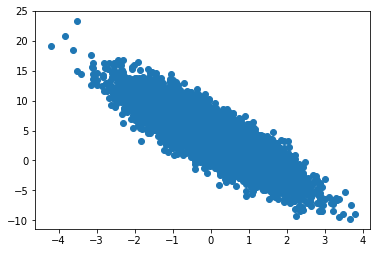

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

In [6]:
batch_size = 4
train_data = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

In [7]:
for data, label in train_data:
    print(data, label)
    break


[[ 0.47278869  0.88282967]
 [-0.01506041 -0.5098654 ]
 [ 0.13778062  0.35881624]
 [ 0.22523411  1.4134928 ]]
<NDArray 4x2 @cpu(0)> 
[ 2.13942742  5.91015673  3.24006629 -0.13357145]
<NDArray 4 @cpu(0)>


In [8]:
counter = 0
for data, label in train_data:
    counter += 1
print(counter)

2500


In [9]:
w = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)
params = [w, b]

In [10]:
for param in params:
    param.attach_grad()

In [11]:
def net(X):
    return mx.nd.dot(X, w) + b

In [12]:
def square_loss(yhat, y):
    return nd.mean((yhat - y) ** 2)

In [13]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [14]:
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

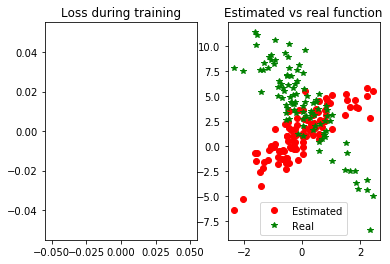

Epoch 0, batch 499. Moving avg of loss: 8.30709417534
Epoch 0, batch 999. Moving avg of loss: 1.20421741142
Epoch 0, batch 1499. Moving avg of loss: 0.160143781912
Epoch 0, batch 1999. Moving avg of loss: 0.0210630294531
Epoch 0, batch 2499. Moving avg of loss: 0.00301629692993


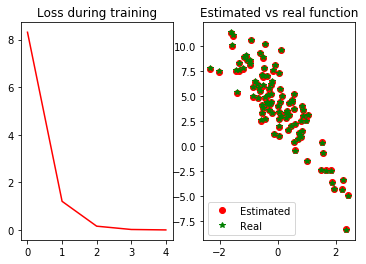

Epoch 1, batch 499. Moving avg of loss: 0.000550240342082
Epoch 1, batch 999. Moving avg of loss: 0.000150820548228
Epoch 1, batch 1499. Moving avg of loss: 0.000105754144325
Epoch 1, batch 1999. Moving avg of loss: 9.39968560611e-05
Epoch 1, batch 2499. Moving avg of loss: 0.000100646151002


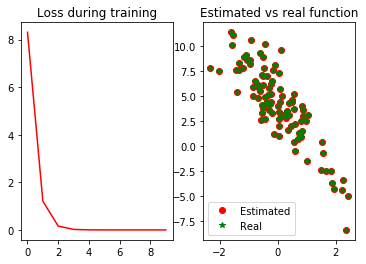

In [15]:
epochs = 2
ctx = mx.cpu()
learning_rate = .001
smoothing_constant = .01
moving_loss = 0
niter = 0
losses = []
plot(losses, X)


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

        if (i + 1) % 500 == 0:
            print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, est_loss))
            losses.append(est_loss)

    plot(losses, X)